In [1]:
import wrds
import pandas as pd
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification

## 1 : Import the articles for each company

In [2]:
# set the directory path
directory = "../articles"

# initialize an empty list to store the data
data = []

# loop through each directory in the Articles directory
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        # loop through each file in the directory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            if os.path.isfile(file_path) and filename.endswith(".json"):
                # read the JSON file
                with open(file_path, "r") as f:
                    json_obj = json.load(f)
                # extract the relevant information from the JSON object
                _id = json_obj["_id"]
                #name of the directory is the company name
                company = subdir
                title = json_obj["title"]
                text = json_obj["text"]
                cleaned_text = re.sub(r'<p>|</p>', '', text)
                #Change to timestamp YYYY-MM-DD HH:MM:SS
                published = json_obj["published"]
                timestamp = datetime.strptime(published, '%Y-%m-%dT%H:%M:%S.%fZ')
                data.append([_id, company, title, cleaned_text, timestamp])
        
df = pd.DataFrame(data, columns=["id", "company", "title", "text", "published"])

In [3]:
#Remove duplicates texts
df = df.sort_values(['company', 'published'])
df = df.drop_duplicates(subset=['company','text'], keep='first')

In [4]:
#print company names
company_to_ticker = {
    '3M_Company': 'MMM',
    'American_Express_co': 'AXP',
    'Amgen_Inc': 'AMGN',
    'Apple_Inc': 'AAPL',
    'Boeing_Co': 'BA',
    'Caterpillar_Inc': 'CAT',
    'Chevron_Corporation': 'CVX',
    'Cisco_Systems_Inc': 'CSCO',
    'Coca_Cola_Co': 'KO',
    'Dow_Inc': 'DOW',
    'Goldman_Sachs_Group_Inc': 'GS',
    'Home_Depot_Inc': 'HD',
    'Honeywell_International_Inc': 'HON',
    'Intel_Corporation': 'INTC',
    'International_Business_Machines_Corporation': 'IBM',
    'JPMorgan_Chase_Co': 'JPM',
    'Johnson_Johnson': 'JNJ',
    'McDonald_s_Corporation': 'MCD',
    'Merck_Co_Inc': 'MRK',
    'Microsoft_Corporation': 'MSFT',
    'Nike_Inc': 'NKE',
    'Procter_Gamble_Co': 'PG',
    'Salesforce_Inc': 'CRM',
    'The_Walt_Disney_Company': 'DIS',
    'Travelers_Companies_Inc': 'TRV',
    'Unitedhealth_Group_Incorporated': 'UNH',
    'Verizon_communications_Inc': 'VZ',
    'Visa_Inc': 'V',
    'Walgreens_Boots_Alliance_Inc': 'WBA',
    'Walmart_Inc': 'WMT'
}

#Replace company names with ticker symbols
df['ticker'] = df['company'].map(company_to_ticker)

## 2 : Data Processing

### 2.1 : Clean articles

In [5]:
#Helpers functions for cleaning text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_ftcom_and_after(text):
    index = text.find("FT.com")
    return text[:index] if index != -1 else text

def remove_source_and_after(text) : 
    index  = text.find("Source:")
    return text[:index] if index != -1 else text

def replace_PG(text):
    return text.replace("P&amp;G", "Procter & Gamble")

In [6]:
#Remove html tags
df['text'] = df['text'].apply(remove_html_tags)

#Remove FT.com and after
df['text'] = df['text'].apply(remove_ftcom_and_after)

#Remove Source: and after
df['text'] = df['text'].apply(remove_source_and_after)

#Change P&G tokens 
df['text'] = df['text'].apply(replace_PG)

#Remove &#xa0; and replace with space
df['text'] = df['text'].str.replace('&#xa0;', ' ')

#Remove "Follow @FT" and after
df['text'] = df['text'].apply(lambda x: x.split("Follow @FT")[0])

#Transform to lower case all text
df['text'] = df['text'].str.lower()

#Remove rows with "Please sign up here
df = df[df['text'] != "Please sign up here"]

In [7]:
# from difflib import SequenceMatcher

# def similar_words(text, target, similarity_threshold=0.8):
#     # Split the text into words
#     words = text.split()

#     # Find words that are similar to the target
#     similar = [word for word in words if SequenceMatcher(None, word, target).ratio() > similarity_threshold]

#     return similar

# df['similar_words'] = df.apply(lambda row: similar_words(row['text'], row['company']), axis=1)

#They are going to give us the list of words that are similar to the company name

In [8]:
ticker_to_company = {'MMM' : '3m',
                     'AXP' : 'american express',
                     'AMGN' : 'amgen',
                     'AAPL' : 'apple',
                     'BA' : 'boeing',
                     'CAT' : 'caterpillar',
                     'CVX' : 'chevron',
                     'CSCO' : 'cisco',
                     'KO' : 'coca cola',
                     'DOW' : 'dow',
                     'GS' : 'goldman sachs',
                     'HD' : 'home depot',
                     'HON' : 'honeywell',
                     'INTC' : 'intel',
                     'IBM' : 'ibm',
                     'JPM' : 'jpmorgan',
                     'JNJ' : 'johnson & johnson',
                     'MCD' : 'mcdonalds',
                     'MRK' : 'merck',
                     'MSFT' : 'microsoft',
                     'NKE' : 'nike',
                     'PG' : 'procter & gamble',
                     'CRM' : 'salesforce',
                     'DIS' : 'walt disney',
                     'TRV' : 'travelers',
                     'UNH' : 'united health',
                     'VZ' : 'verizon',
                     'V' : 'visa',
                     'WBA' : 'walgreens',
                     'WMT' : 'walmart'}

df['company_words'] = df['ticker'].map(ticker_to_company)

In [9]:
df['text'] = df['text'].str.lower()
#Delete punctuation except '.'
df['text'] = df['text'].str.replace('[^\w\s\.]','')

/var/folders/hv/67_537bx1cb2f2v1x8cw8k0m0000gn/T/ipykernel_10431/788995560.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s\.]','')


In [10]:
def select_sentences(text, company_words, before=0, after=0):
    # Split the text into sentences
    sentences = text.split('. ')

    # Find the indices of the sentences where the company name appears
    indices = [i for i, sentence in enumerate(sentences) if company_words in sentence]

    # If the company name does not appear, return an empty list
    if not indices:
        return []

    # Initialize the list of selected sentences
    selected = []

    # Iterate over the indices
    for i in range(len(indices)):
        # If this is the first index, select the sentences before it
        if i == 0:
            start = max(0, indices[i]-before)
        # Otherwise, select the sentences after the previous index
        else:
            start = max(indices[i-1] + after + 1, indices[i]-before)

        # Select the sentences before, at, and after the current index
        end = indices[i] + after + 1
        selected.extend(sentences[start:end])

    return selected

# Apply the function to each row in the dataframe : we only keep the sentences that contain the company name and the sentences before and after
df['sentences'] = df.apply(lambda row: select_sentences(row['text'], row['company_words']), axis=1)

In [11]:
#For delete the sentences that contain Listen on:
df['sentences'] = df.apply(lambda row: [sentence for sentence in row['sentences'] if 'listen on:' not in sentence], axis=1)

In [12]:
#Delete the text column
df = df.drop(columns=['text'])

#Copy the dataframe
df_articles_cleaned = df.copy(deep = True)

In [13]:
#Now we remove the articles that don't contain sentences about the company we are focusing on, so articles with an empty list of sentences
df_articles_cleaned = df_articles_cleaned[df_articles_cleaned.astype(str)['sentences'] != '[]']

### 2.2 : Dive into the articles and their structure

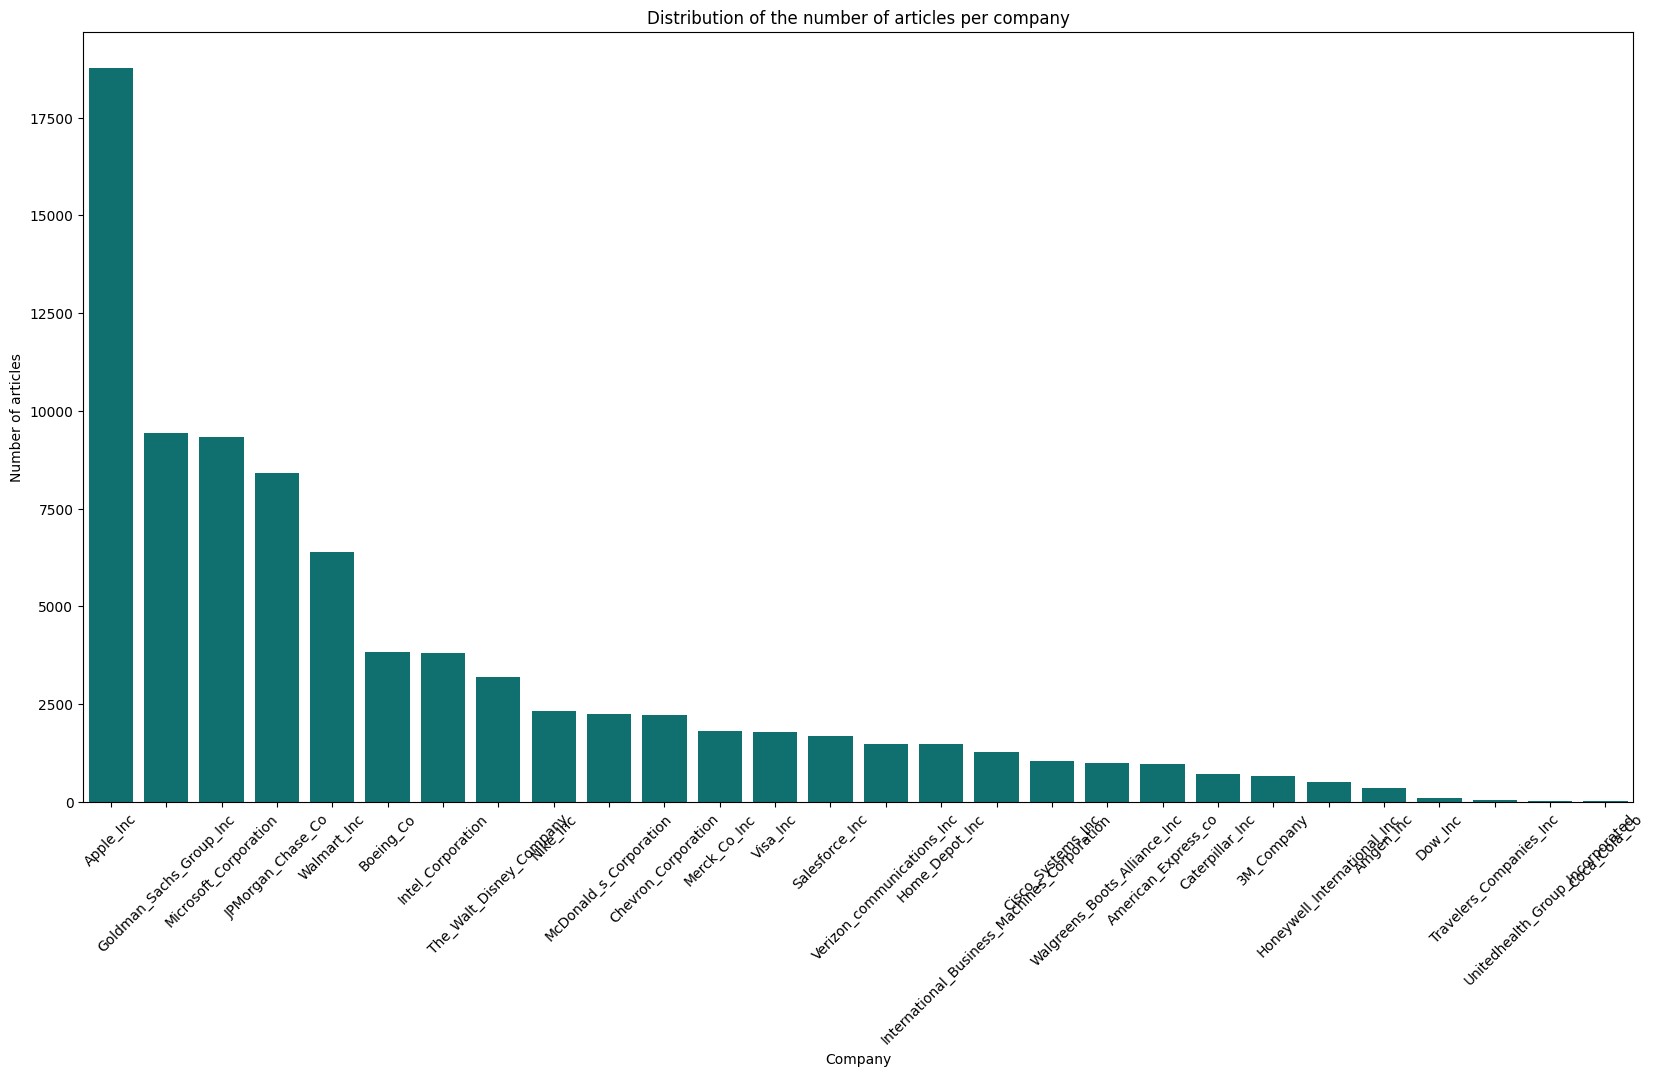

In [14]:
#Now we will dive into the distribution of the number of articles per company
plt.figure(figsize = (20,10))

count = df_articles_cleaned.groupby('company').count()['id'].sort_values(ascending = False)

ax = sns.barplot(
    x = count.index , 
    y = count.values , 
    color = 'teal', 
)

ax.set_title('Distribution of the number of articles per company')
ax.set_xlabel('Company')
ax.set_ylabel('Number of articles')

plt.xticks(rotation=45)
plt.show()

In [24]:
df_articles_cleaned.groupby('ticker').count()['id'].sort_values(ascending = False)

ticker
AAPL    18755
GS       9427
MSFT     9318
JPM      8409
WMT      6386
BA       3831
INTC     3786
DIS      3201
NKE      2326
MCD      2233
CVX      2221
MRK      1817
V        1792
CRM      1675
HD       1474
VZ       1474
IBM      1275
CSCO     1050
WBA       989
AXP       969
CAT       706
MMM       646
HON       496
AMGN      357
DOW       106
TRV        55
UNH        11
KO          9
Name: id, dtype: int64

We can see that we have a really important representation of Apple articles and it dominates all the other companies in the dataset. We will further try to understand the articles related to Apple in order to check wether there is any discontinuities. 

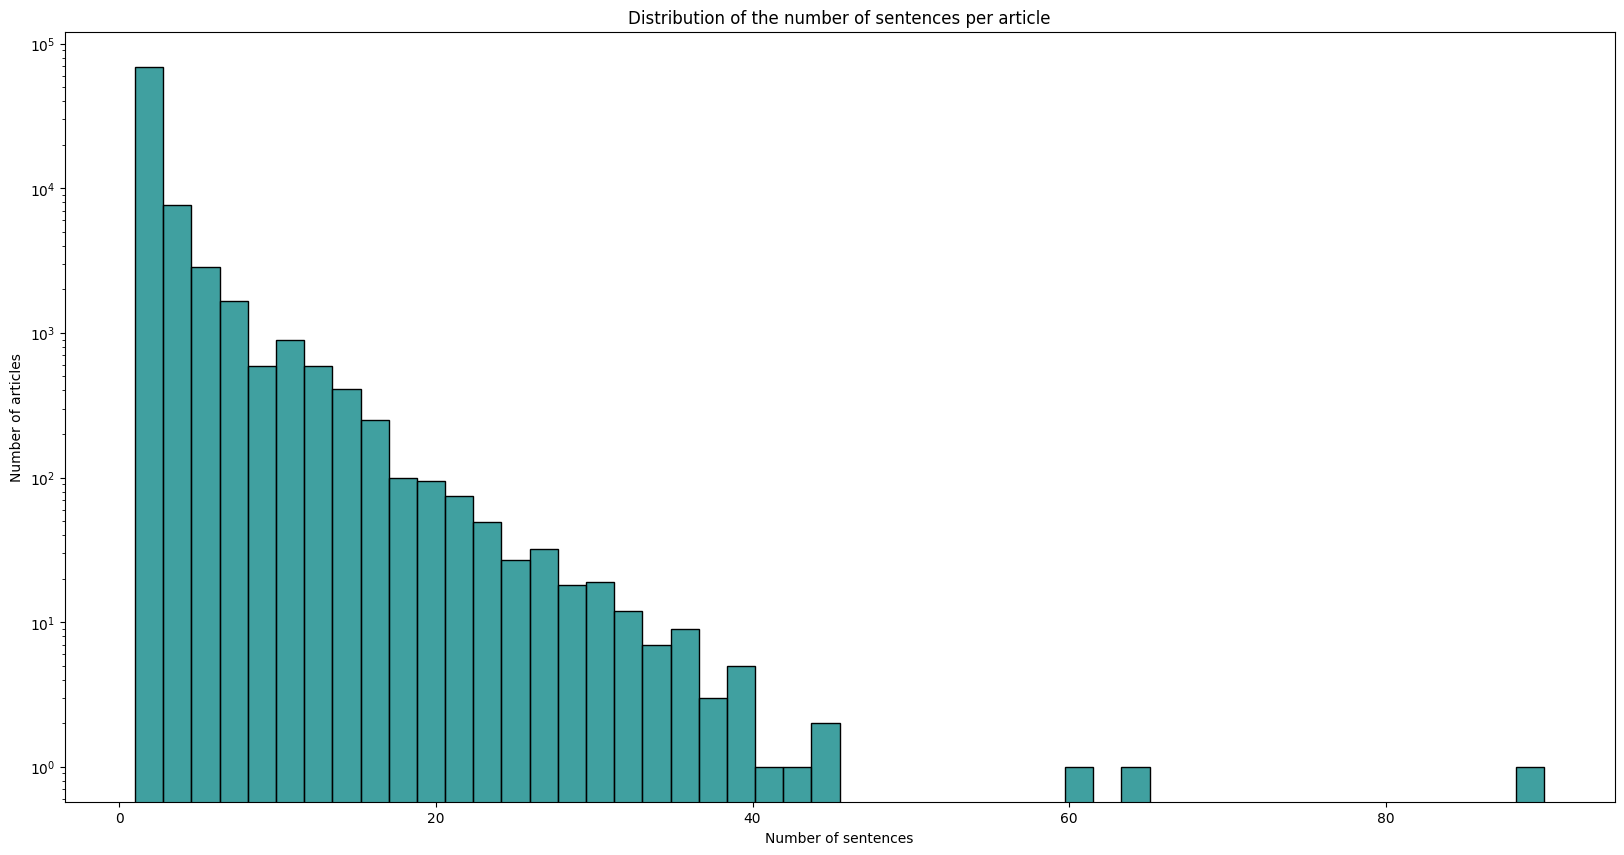

In [15]:
#We look at the distribution of the number of sentences per article
plt.figure(figsize = (20,10))

count = df_articles_cleaned['sentences'].apply(lambda x: len(x))

sns.histplot(count, color='teal', bins=50 , log = True)

plt.title('Distribution of the number of sentences per article')
plt.xlabel('Number of sentences')
plt.ylabel('Number of articles')

plt.show()

We plotted the log distribution of the number of sentences per article. We see that a really important number of articles have only a few sentences, i.e between 1 and 4. This is interesting as it shows that among the articles that we did not remove because they were not including texts about the company, contain only a small fraction of information about the specific company. So by only looking at the sentences talking about the company + previous and following sentence we can be quite sure that we kept the necessary information related to the company. 

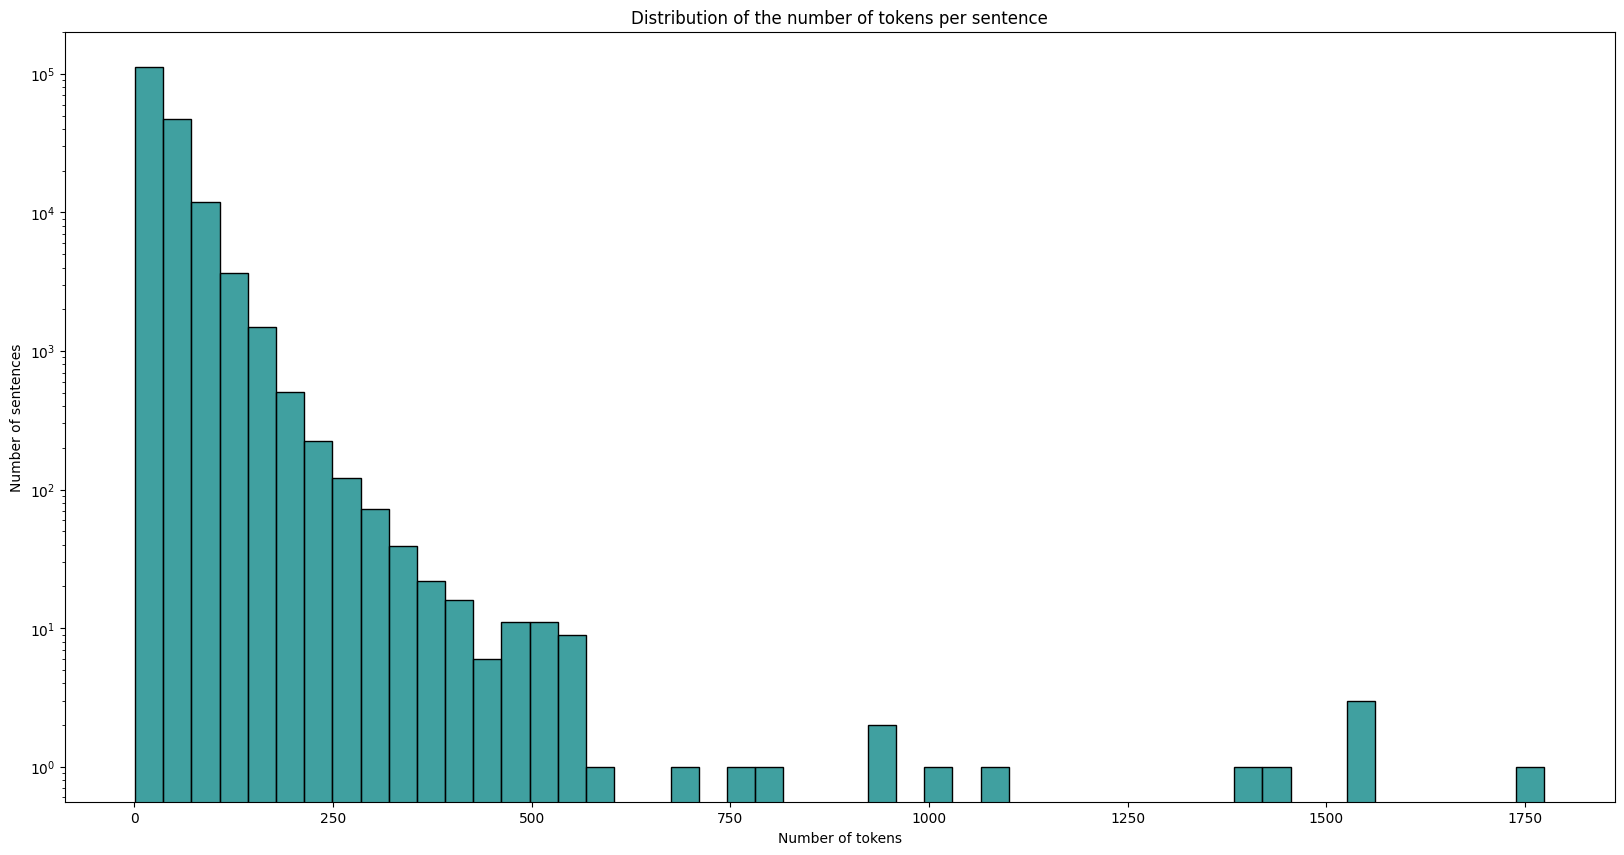

count    178104.000000
mean         36.695689
std          33.611270
min           1.000000
25%          17.000000
50%          29.000000
75%          46.000000
max        1774.000000
dtype: float64

In [16]:
#We know that most NLP models require in input a specific number of tokens so we will check the distribution of the number of tokens per sentence
plt.figure(figsize = (20,10))

count = df_articles_cleaned['sentences'].apply(lambda x: [len(sentence.split()) for sentence in x]).explode()

sns.histplot(count, color='teal', bins=50 , log = True)

plt.title('Distribution of the number of tokens per sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Number of sentences')

plt.show()

series = pd.Series(count.values).astype(float)  # Convert to float if they are all numbers
series.describe()

Again, we have most of the sentences following the same pattern, i.e, they all have a small number of tokens, so they will be easily fed to future NLP models, we see that 75% of the sentences have less than 49 tokens. However, we still have to deal with the senteces that have more than 500 tokens as we won't be able to feed them to NLP models.

In [17]:
#Look at the articles that have sentences with more than 500 tokens
df_articles_cleaned['len_sentences'] = df_articles_cleaned['sentences'].apply(lambda x: [len(sentence.split()) for sentence in x])

#We print the number of articles that have sentences with more than 500 tokens
articles_more_500_tokens = df_articles_cleaned[df_articles_cleaned["len_sentences"].apply(lambda x: max(x)) > 500]
print(f'The number of articles that have sentences with more than 500 tokens is {len(articles_more_500_tokens)}')

#For each company containing articles with sentences with more than 500 tokens, we print he ratio of articles with sentences with more than 500 tokens
for company in articles_more_500_tokens['company'].unique():
    print(f'The ratio of articles with sentences with more than 500 tokens for {company} is {len(articles_more_500_tokens[articles_more_500_tokens["company"] == company]) / len(df_articles_cleaned[df_articles_cleaned["company"] == company])}')
    

The number of articles that have sentences with more than 500 tokens is 33
The ratio of articles with sentences with more than 500 tokens for 3M_Company is 0.0015455950540958269
The ratio of articles with sentences with more than 500 tokens for Apple_Inc is 0.00026652452025586353
The ratio of articles with sentences with more than 500 tokens for Boeing_Co is 0.0005217845030002609
The ratio of articles with sentences with more than 500 tokens for Caterpillar_Inc is 0.0014144271570014145
The ratio of articles with sentences with more than 500 tokens for Chevron_Corporation is 0.00045004500450045
The ratio of articles with sentences with more than 500 tokens for Goldman_Sachs_Group_Inc is 0.000741997032011872
The ratio of articles with sentences with more than 500 tokens for Intel_Corporation is 0.0013189132155104195
The ratio of articles with sentences with more than 500 tokens for McDonald_s_Corporation is 0.0013416815742397137
The ratio of articles with sentences with more than 500 tok

We see that for each of the company that have more that articles with more than 500 tokens, the number of those article is unsignificant regarding the total number of articles we have for those companies so we decide to remove those articles

In [18]:
#Remove the articles that have sentences with more than 500 tokens
df_articles_cleaned = df_articles_cleaned[df_articles_cleaned["len_sentences"].apply(lambda x: max(x)) <= 500]

### 2.3 : Dive into the balance of the data

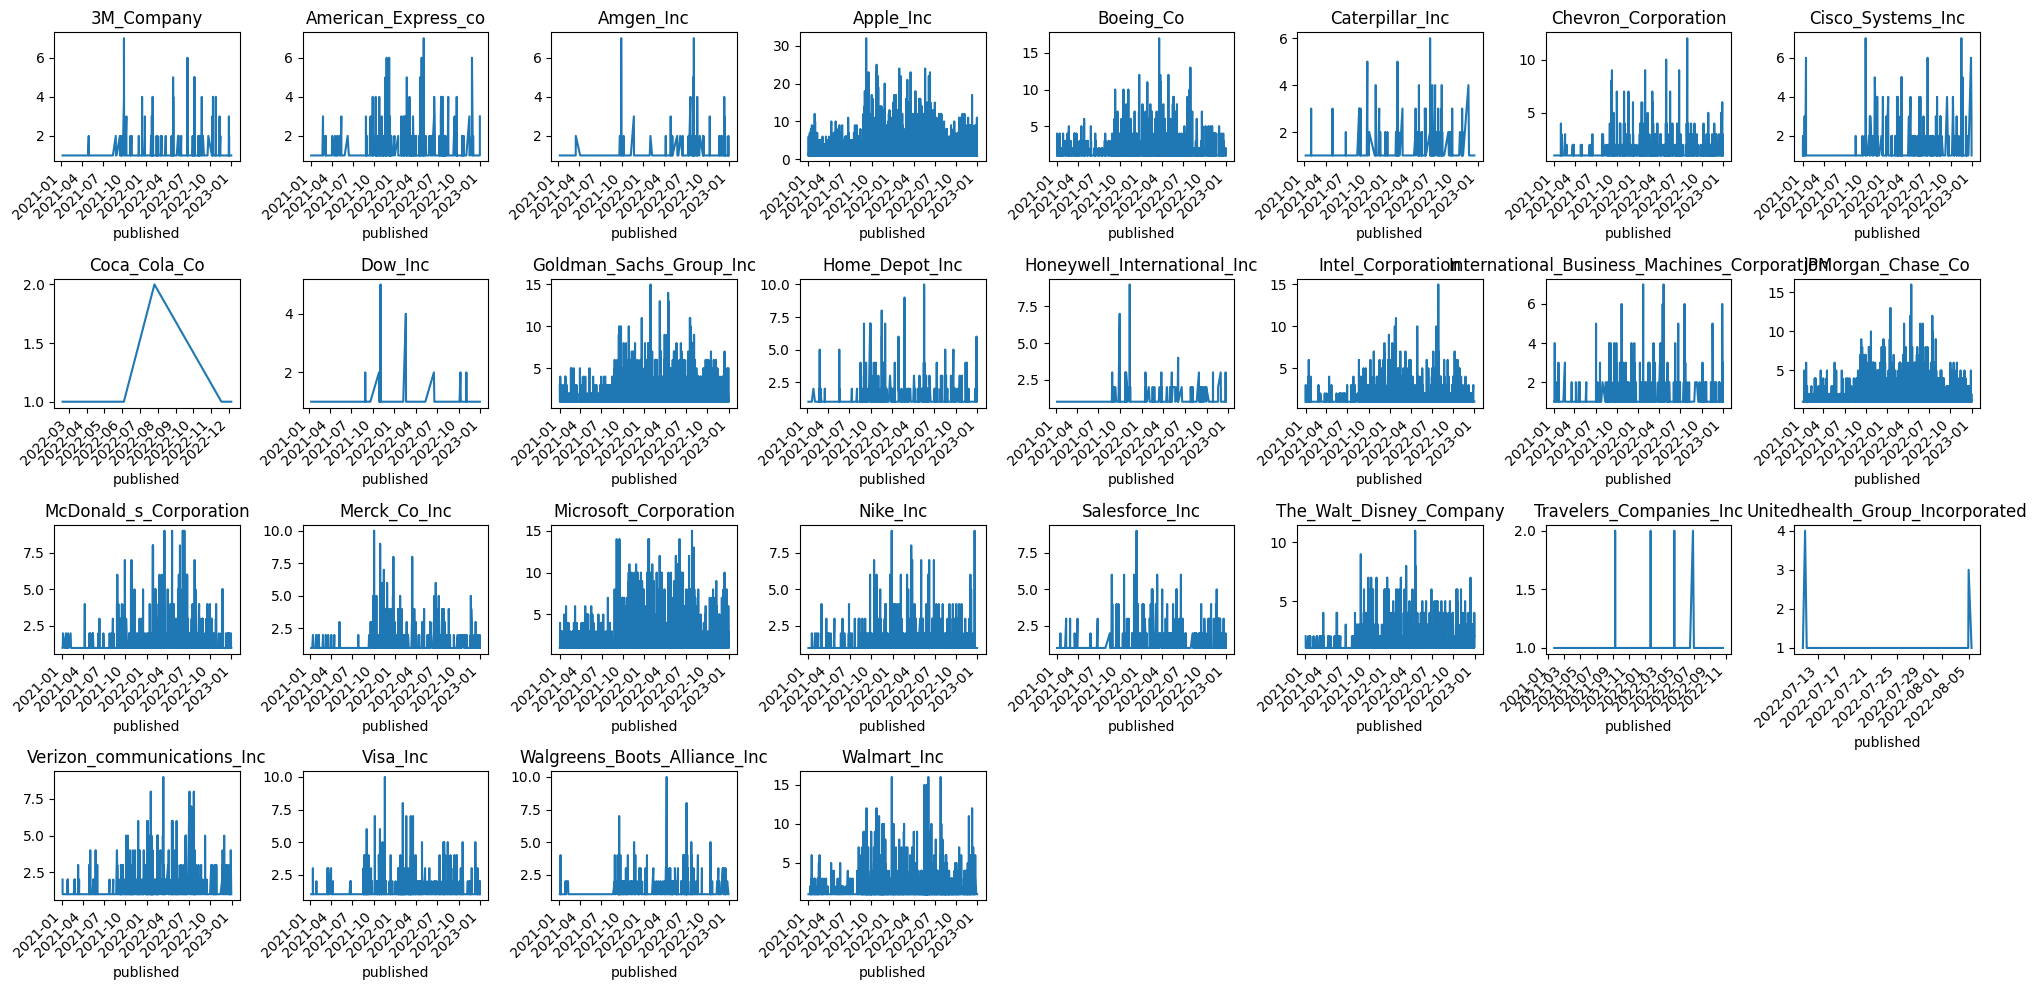

In [19]:
#We plot the number of articles we have over time for each company with a subplot for each company
plt.figure(figsize = (20,10))

for i, company in enumerate(df_articles_cleaned['company'].unique()):
    plt.subplot(4, 8, i+1)
    plt.title(company)
    df_articles_cleaned[df_articles_cleaned['company'] == company].groupby('published').count()['id'].plot()
    plt.xticks(rotation=45)
    plt.tight_layout()


In [21]:
#Save the dataframe to a csv file
df.to_csv('../data/news_cleaned.csv', index=True, sep=';')